# Modeling
### plan
> 1) 기상청 데이터를 활용해서 외부 날씨 예측 => 시계열
    * 이때, test데이터에는 30분 단위 값도 있고, 기상청 데이터는 1시간 단위이므로 기상청 데이터에 30분단위도 추가필요
    * 같은시간대의 데이터만 가져와서 시간대별로 예측하는 방식
> 2) 외부 날씨로 공장내부 온도,습도,코일온도,이슬점온도 등을 예측 => 회귀

> 3) 공장내부 온도,습도,코일온도,이슬점온도 등의 정보로 결로현상 예측 => 분류, 로지스틱회귀


In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [137]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [195]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 당진
# dangjin_humid=pd.read_csv('./data/dangjin_humid.csv',index_col=None)
# dangjin_rain=pd.read_csv('./data/dangjin_rain.csv',index_col=None)
# dangjin_tem=pd.read_csv('./data/dangjin_tem.csv',index_col=None)

# 신평
# shinpyung_humid=pd.read_csv('./data/shinpyung_humid.csv',index_col=None)
# shinpyung_rain=pd.read_csv('./data/shinpyung_rain.csv',index_col=None)
# shinpyung_tem=pd.read_csv('./data/shinpyung_tem.csv',index_col=None)

# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

# test데이터셋과 동일하게 train 데이터 전처리
# plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0])

In [167]:
# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])
seosan=seosan.rename(columns={'일시':'date','기온(°C)':'tem','습도(%)':'hum','이슬점온도(°C)':'dew','증기압(hPa)':'vapor'})

### 컬럼명 전처리

In [197]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

### 기온, 습도, 이슬점온도 컬럼 분리

In [168]:
# 30분단위 추가 전
seosan_hum=seosan[['date','hum']]
seosan_dew=seosan[['date','dew']]
seosan_tem=seosan[['date','tem']]
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

### 30분 단위 추가

In [169]:
seosan.shape

(35198, 37)

In [179]:
index_30min=pd.date_range('2016-04-01 00:30:00', periods=35231, freq='H')
index_30min=index_30min.to_frame().rename(columns={0:'date'})
seosan2=pd.concat([seosan,index_30min],ignore_index=True)
seosan2=seosan2.sort_values('date').reset_index(drop=True)
seosan2=seosan2[['date','tem','hum','dew','vapor']]
seosan2

,date,tem,hum,dew,vapor
0,2016-04-01 00:00:00,8.8,41.0,-3.7,4.6
1,2016-04-01 00:30:00,NaN,NaN,NaN,NaN
2,2016-04-01 01:00:00,9.2,34.0,-5.8,4.0
3,2016-04-01 01:30:00,NaN,NaN,NaN,NaN
4,2016-04-01 02:00:00,9.2,33.0,-6.2,3.8
...,...,...,...,...,...
70424,2020-04-07 21:00:00,7.7,89.0,5.9,9.3
70425,2020-04-07 21:30:00,NaN,NaN,NaN,NaN
70426,2020-04-07 22:00:00,6.4,72.0,1.7,6.9
70427,2020-04-07 22:30:00,NaN,NaN,NaN,NaN


### 결측값 보간

In [180]:
seosan2=seosan2.interpolate()
seosan2

,date,tem,hum,dew,vapor
0,2016-04-01 00:00:00,8.80,41.0,-3.70,4.6
1,2016-04-01 00:30:00,9.00,37.5,-4.75,4.3
2,2016-04-01 01:00:00,9.20,34.0,-5.80,4.0
3,2016-04-01 01:30:00,9.20,33.5,-6.00,3.9
4,2016-04-01 02:00:00,9.20,33.0,-6.20,3.8
...,...,...,...,...,...
70424,2020-04-07 21:00:00,7.70,89.0,5.90,9.3
70425,2020-04-07 21:30:00,7.05,80.5,3.80,8.1
70426,2020-04-07 22:00:00,6.40,72.0,1.70,6.9
70427,2020-04-07 22:30:00,6.50,64.0,0.10,6.2


In [183]:
# 결측치 없는것 확인.
print('기온 결측치:',seosan_tem2.isnull().sum())
print('습도 결측치:',seosan_hum2.isnull().sum())
print('이슬점온도 결측치:',seosan_dew2.isnull().sum())

기온 결측치: date    0
tem     0
dtype: int64
습도 결측치: date    0
hum     0
dtype: int64
이슬점온도 결측치: date    0
dew     0
dtype: int64


### 30분단위 추가 후  기온, 습도, 이슬점온도 분류

In [181]:
# 30분단위 추가 후  기온, 습도, 이슬점온도 분류
seosan_hum2=seosan2[['date','hum']]
seosan_dew2=seosan2[['date','dew']]
seosan_tem2=seosan2[['date','tem']]
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

In [182]:
seosan_tem2.head()

,date,tem
0,2016-04-01 00:00:00,8.8
1,2016-04-01 00:30:00,9.0
2,2016-04-01 01:00:00,9.2
3,2016-04-01 01:30:00,9.2
4,2016-04-01 02:00:00,9.2


------------------------------------------------------------------------------------------------------------------------------------------------
## ARIMAX
[참고] http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels <br>
* 특정 시간대 하나만 가져와서 그걸로 ARIMAX적용해서 결과 비교
* statsmodels의 시계열 모형 클래스 ARMA, ARIMA, SARIMAX 등은 모두 외부 시계열의 영향을 포함하기 위한 exog 라는 인수를 가지고 있다.<br>
    이 인수가 주어지면 기존의 모형에 외부 시계열에 대한 선형 회귀항이 포함된다.
* model의 모든 variable이 stationary해야 한다. 

In [191]:
def get_time_delta(data, hour_,minute_):
    """
    시간, 분 지정하면 해당 시간대만 가져오도록
    """
    data['hour']=data['date'].dt.hour
    data['minute']=data['date'].dt.minute
    if hour_ and minute_ =="total":
        target=data[['date','tem','vapor']]
    else:
        target=data.loc[(data.hour==hour_) & (data.minute==minute_)][['date','tem','vapor']]
#     target[['tem','vapor']].plot(kind='line')
    return target.set_index('date')

In [192]:
# 4시반 데이터만 일자별로 가져오기
hour4_30=get_time_delta(seosan2,4,30)
hour4_30

,tem,vapor
date,,
2016-04-01 04:30:00,4.20,4.80
2016-04-02 04:30:00,4.60,7.70
2016-04-03 04:30:00,8.90,11.00
2016-04-04 04:30:00,7.15,9.35
2016-04-05 04:30:00,1.50,6.45
...,...,...
2020-04-03 04:30:00,1.55,6.40
2020-04-04 04:30:00,6.05,9.05
2020-04-05 04:30:00,4.10,2.60


#### 정상성 확인
* ARIMAX에서는 모든 변수가 stationary 해야함.

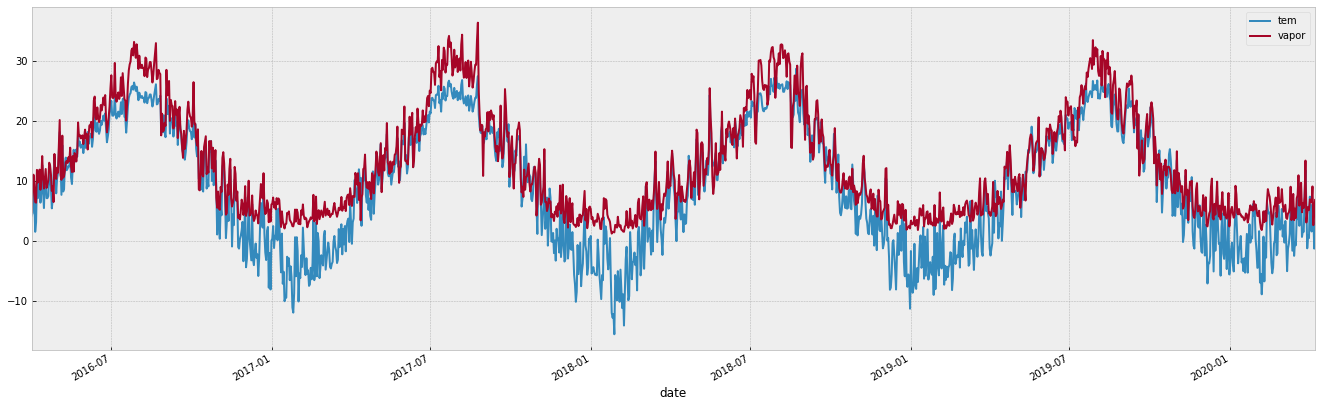

In [243]:
fig,ax=plt.subplots()
fig.set_size_inches(23,7)
hour4_30[['tem','vapor']].plot(ax=ax)
plt.show()

In [226]:
from statsmodels.tsa.stattools import adfuller

In [244]:
# vapor변수 정상성 검증 
print( "검정통계량:" ,adfuller(hour4_30['vapor'])[0])
print( "p-value:" ,adfuller(hour4_30['vapor'])[1])
print( "사용된 시차의 수:" ,adfuller(hour4_30['vapor'])[2])
print( "자료의 수:" ,adfuller(hour4_30['vapor'])[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(hour4_30['vapor'])[4])

검정통계량: -1.8039995777484341
p-value: 0.37847783005908653
사용된 시차의 수: 12
자료의 수: 1455
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}


#### 정상화 Stationarize
* vapor변수 1차 차분후 정상화됨.

In [246]:
# 차분 후 정상성 검증 
diff_1=hour4_30['vapor'].diff(periods=1).iloc[1:]

print( "검정통계량:" ,adfuller(diff_1)[0])
print( "p-value:" ,adfuller(diff_1)[1])
print( "사용된 시차의 수:" ,adfuller(diff_1)[2])
print( "자료의 수:" ,adfuller(diff_1)[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(diff_1)[4])

검정통계량: -15.809107478386219
p-value: 1.0518618516792121e-28
사용된 시차의 수: 11
자료의 수: 1455
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}


**ARIMA모델에 exog인수 추가**
* import pyflux as pf 에서 pf.ARIMAX 도 있는데 이건 formula값을 어떻게 넣어야할지..
* ARIMAX모델에서는 auto arima 다르게 적용되는지 

In [251]:
# 외부 시계열의 영향을 포함하기 위한 exog 라는 인수
m2 = sm.tsa.ARIMA(hour4_30.tem,  exog=hour4_30.vapor,order=[2,2,1])
r2 = m2.fit()
print(r2.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.tem   No. Observations:                 1466
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -3826.961
Method:                       css-mle   S.D. of innovations              3.283
Date:                Mon, 08 Jun 2020   AIC                           7665.923
Time:                        13:27:34   BIC                           7697.665
Sample:                    04-03-2016   HQIC                          7677.761
                         - 04-07-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0044      0.001      3.086      0.002       0.002       0.007
vapor           -0.0003      0.000     -3.120      0.002      -0.001      -0.000
ar.L1.D2.tem    -0.3528      0.025    -14.03

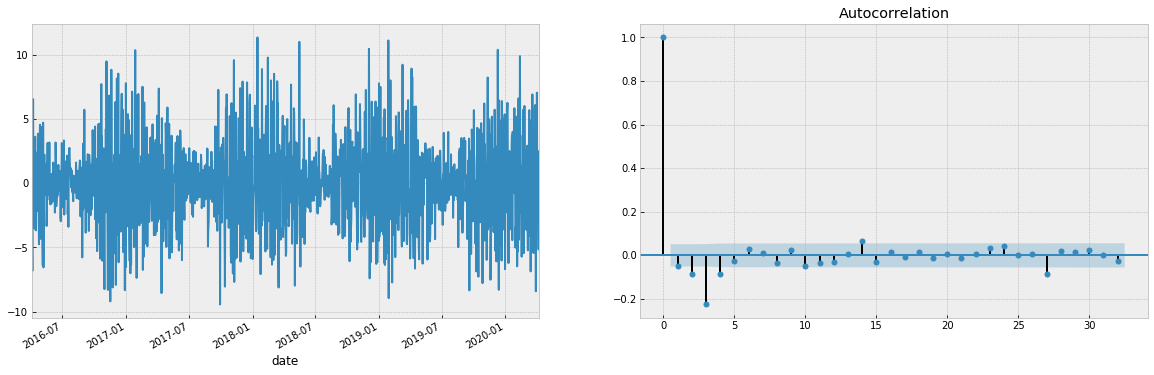

In [252]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(20,6)
r2.resid.plot(ax=ax1)
sm.tsa.graphics.plot_acf(r2.resid, ax=ax2)
plt.show()

In [259]:
############################################## exog= vapor로 지정해서 ARIMAX 모형구축
from statsmodels.tsa.arima_model import ARIMA
# i = 500,501,502,,,,1468
hour4_30=get_time_delta(seosan2,4,30)

prediction=[]
actual=[]
period=500
for i in range(0, hour4_30.shape[0]-500-1):   # i = 0~966 (총1467이지만 그전까지 예측해야하므로)
    train=hour4_30.iloc[ i: period+i]  # train= 0~500, 1~501, 2~502 ...(1466-500)=966~1466
    test=hour4_30.iloc[period+(i+1)]['tem']  # 501,502,503,,,,1467
    model = ARIMA(train,  exog=hour4_30.vapor,order=[2,2,1])
    model_fit = model.fit()
    fore = model_fit.forecast(steps=1)
    
    prediction.append(fore[0][0])    # 예측값
    actual.append(test)      # 실제값

# prediction plot 과 실제값(test) plot 그리기.
fig,ax=plt.subplots()
fig.set_size_inches(22,8)
fig=plt.plot(prediction)
fig=plt.plot(actual)
plt.legend(['prediction','actual'])
plt.show()

ValueError: The indices for endog and exog are not aligned

In [205]:
plant_test.head()

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
1,2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
2,2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
3,2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
4,2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
5,2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN
